# Setup

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from IPython.display import display, HTML, Image
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {} numpy version: {} sklearn version: {}".format(pd.__version__, 
                                                                        np.__version__, sklearn.__version__))

def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

%matplotlib notebook
import matplotlib.pyplot as plt

pandas version: 0.24.2 numpy version: 1.16.4 sklearn version: 0.21.2


# Daily Precipitation Report Analysis

### Load Data - 460K records

In [2]:
data_url = ('https://cocorahsai.blob.core.windows.net/notes/percent_5.csv')
df = pd.read_csv(data_url, names=['notes'], sep=u'\0091')
df['notes'] = df['notes'].astype('str')
print(len(df))

460485


## Hail Size and Duration

In [3]:
words = ['hail']
df_3 = df[np.logical_and.reduce([df['notes'].str.contains(word, case = False) for word in words])]
print('words: [{}] count: {} percent: {}%'.format(', '.join(words), len(df_3), round(len(df_3)/len(df)*100,1)))

words = ['hail', 'size']
df_3 = df[np.logical_and.reduce([df['notes'].str.contains(word, case = False) for word in words])]
print('words: [{}] count: {} percent: {}%'.format(', '.join(words), len(df_3), round(len(df_3)/len(df)*100,1)))

words: [hail] count: 4136 percent: 0.9%
words: [hail, size] count: 1516 percent: 0.3%


In [4]:
def get_size(x):
    ans = re.findall(r'[\w-]+\s*size|[\d./]+\s*"|[\d./]+\s*inch', x, re.IGNORECASE)
    if len(ans) > 0:
        return ', '.join(ans)
    return None

def get_duration(x):
    ans = re.findall(r'[\w]+\s*min|[\w]+\s*hour\b|[\w]+\s*hr\b', x, re.IGNORECASE)
    if len(ans) > 0:
        return ', '.join(ans)
    return None

In [5]:
df_3['size'] = df_3['notes'].apply(lambda x: get_size(x))
df_3['duration'] = df_3['notes'].apply(lambda x: get_duration(x))
df_3.head(20)

,notes,size,duration
107,"pea sized hail, very high winds",pea size,None
120,small amount of pea size hail,pea size,None
210,"A ""couple"" of pea size hailstones fell.",pea size,None
507,"At 11:30 AM hail started falling, lasting at least 20 minutes. Soft, mostly white, a few clear, mostly rice size. Maximum 1/4"".","rice size, 1/4""",20 min
740,PEA SIZED HAIL FOR ONE MINUTE,PEA SIZE,ONE MIN
767,"a smattering of hail, pebble size",pebble size,None
888,Pea-size hail mixed w/ rain from 1:20 (not sure of exact start time) to 1:36 PM.,Pea-size,None
1420,Brief marble sized hail approximately 30 minutes apart.,marble size,30 min
1552,Brief pea size and smaller hail aprox. 7 P.M. 6/3,pea size,None
1819,Rain included hail (pea size or smaller) from 2:03 to 2:24,pea size,None


# Condition Monitoring Analysis

### Load Data - 42K records

In [6]:
import urllib, json
url = 'https://cocorahsai.blob.core.windows.net/notes/condition_monitor_2.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
df_c = pd.DataFrame.from_dict(data)
df_c = df_c[np.isfinite(df_c['ScaleBar'])]
print(len(df_c))

42013


### Scale Bar Distribution

<IPython.core.display.Javascript object>


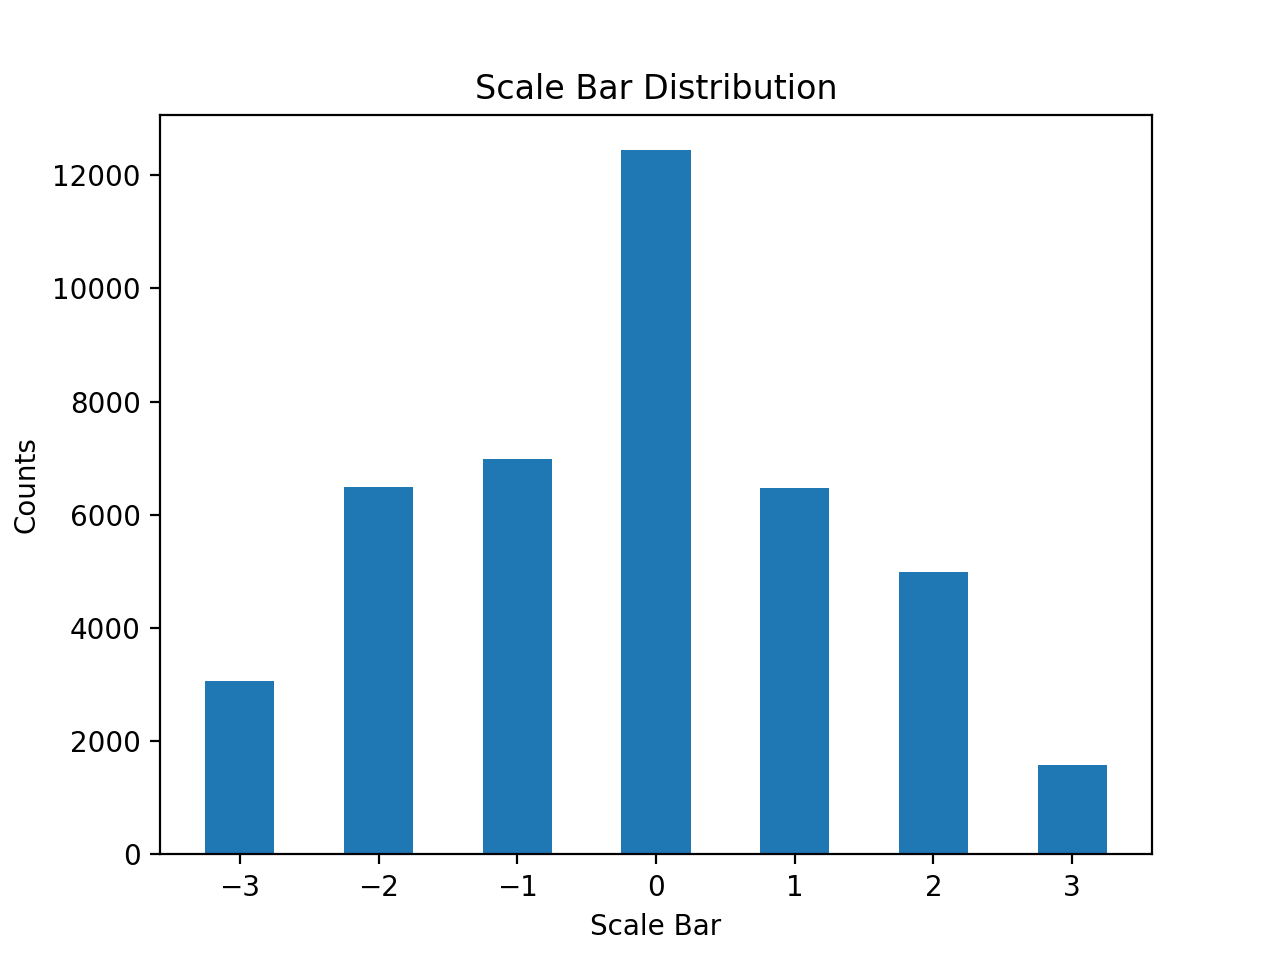

Text(0.5, 1.0, 'Scale Bar Distribution')

In [7]:
unique, counts = np.unique(df_c.ScaleBar.values, return_counts=True)
plt.figure()
plt.bar(unique, counts, width = 0.5)
ax = plt.gca()
ax.set_xlabel('Scale Bar')
ax.set_ylabel('Counts')
ax.set_title('Scale Bar Distribution')

### Manual Tagging Analysis

In [8]:
manual_df = pd.read_csv('https://cocorahsai.blob.core.windows.net/notes/test/full_manual.csv')
labeled_df = pd.read_csv('https://cocorahsai.blob.core.windows.net/notes/test/desc_manual_edited.csv')
labeled_df_n = labeled_df[np.isfinite(labeled_df['Rating'])]
merged = pd.merge(labeled_df_n, manual_df, how='inner', left_on = 'ConditionMonitoringReportID', 
                  right_on = 'ConditionMonitoringReportID')
merged.sort_values(by=['ScaleBar'], ascending=True, inplace=True)
print(len(merged))

207


In [9]:
n_df = merged.where(merged['ScaleBar'] == merged['Rating']).dropna()
print('{}%'.format(round(len(n_df)/len(merged) * 100, 0)))

37.0%


<IPython.core.display.Javascript object>


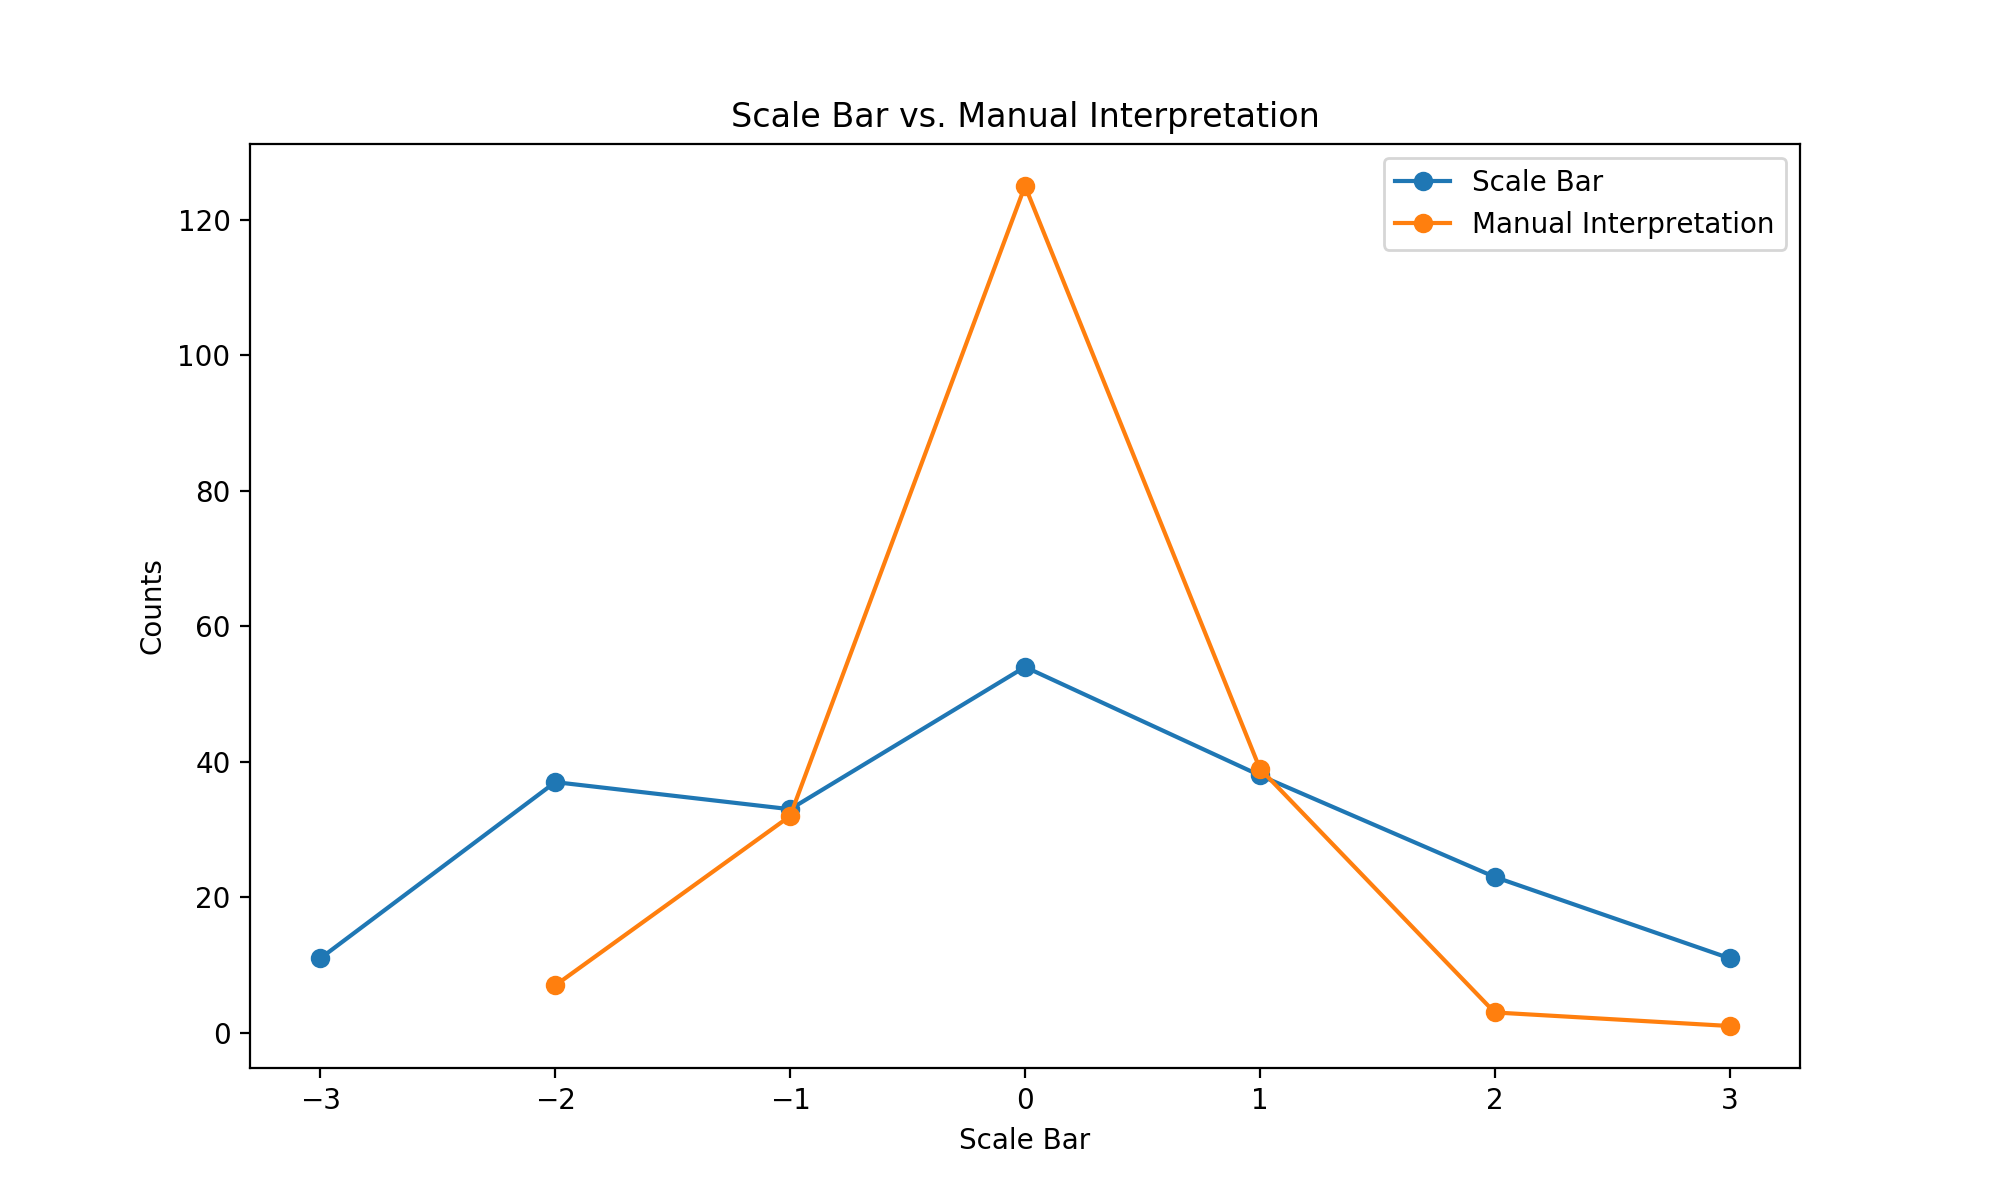

In [10]:
scale_1, counts_SB = np.unique(merged.ScaleBar.values, return_counts=True)
scale_2, counts_Rating = np.unique(merged.Rating.values, return_counts=True)
fig = plt.figure(figsize=(10,6))
plt.plot(scale_1, counts_SB, '-o',  scale_2, counts_Rating, '-o')
ax = plt.gca()
ax.set_xlabel('Scale Bar')
ax.set_ylabel('Counts')
ax.set_title('Scale Bar vs. Manual Interpretation')
plt.legend(['Scale Bar', 'Manual Interpretation'])

### Scale Bar and Observation Type Analysis

In [11]:
condition_map = {'SEVERELY DRY': -3, 'MODERATELY DRY': -2, 'MILDLY DRY': -1, 'NEAR NORMAL': 0, 
                 'MILDLY WET': 1, 'MODERATELY WET': 2, 'SEVERELY WET': 3}

b_cols = ['IsAgriculture', 'IsBusinessAndIndustry', 'IsEnergy', 
          'IsFire', 'IsGeneralAwareness', 'IsPlantsAndWildlife', 
          'IsReliefResponse', 'IsSocietyAndPublicHealth', 
          'IsTourismAndRecreation', 'IsWaterSupplyAndQuality']

df_cm_cols = ['SEVERELY DRY', 'SEVERELY DRY', 
              'MODERATELY DRY', 'MODERATELY DRY', 
              'MILDLY DRY', 'MILDLY DRY', 
              'NEAR NORMAL', 'NEAR NORMAL', 
              'MILDLY WET', 'MILDLY WET', 
              'MODERATELY WET', 'MODERATELY WET', 
              'SEVERELY WET', 'SEVERELY WET']

df_b_cols = ['IsAgriculture', 'IsAgriculture', 
             'IsBusinessAndIndustry', 'IsBusinessAndIndustry', 
             'IsEnergy', 'IsEnergy', 
             'IsFire', 'IsFire', 
             'IsGeneralAwareness', 'IsGeneralAwareness', 
             'IsPlantsAndWildlife', 'IsPlantsAndWildlife', 
             'IsReliefResponse', 'IsReliefResponse', 
             'IsSocietyAndPublicHealth', 'IsSocietyAndPublicHealth', 
             'IsTourismAndRecreation', 'IsTourismAndRecreation', 
             'IsWaterSupplyAndQuality', 'IsWaterSupplyAndQuality']

In [12]:
def get_bcounts(name, data):
    counts = []
    for i in range(len(b_cols)):
        cnts = data[b_cols[i]].value_counts()
        counts.append(cnts.loc[True])
        counts.append(round(cnts.loc[True]*100.0/len(data), 1))
    return counts

all_counts = []
for key, value in condition_map.items():
    t_df = df_c[df_c['ScaleBar'] == value]
    all_counts.append(get_bcounts(key, t_df))

In [13]:
cols_1 = [df_b_cols, ['Counts', 'Percent'] * len(b_cols)]
counts_by_condt_df = pd.DataFrame(np.array(all_counts), index = list(condition_map.keys()), columns = cols_1)
display_dataframe(counts_by_condt_df)

cols_2 = [df_cm_cols, ['Counts', 'Percent'] * len(list(condition_map.keys()))]
all_counts_cm = []
for i in range(0, len(b_cols) * 2, 2):
    c_col = counts_by_condt_df.iloc[:, i]
    counts = []
    for j in range(len(list(condition_map.keys()))):
        counts.append((int(c_col.iloc[j]), round(c_col.iloc[j] * 100 /  c_col.sum(),1)))
    all_counts_cm.append(counts)
counts_by_type_df = pd.DataFrame(np.reshape(np.array(all_counts_cm), (len(b_cols), -1)), 
                             index = b_cols, columns = cols_2)
display_dataframe(counts_by_type_df)

#### Type Distribution by Scale Bar

In [14]:
def get_row_data(data, row_index):
    results = []
    for index, value in data.loc[row_index].items():
        if index[1] == 'Percent':
            results.append(value)
    return results

<IPython.core.display.Javascript object>


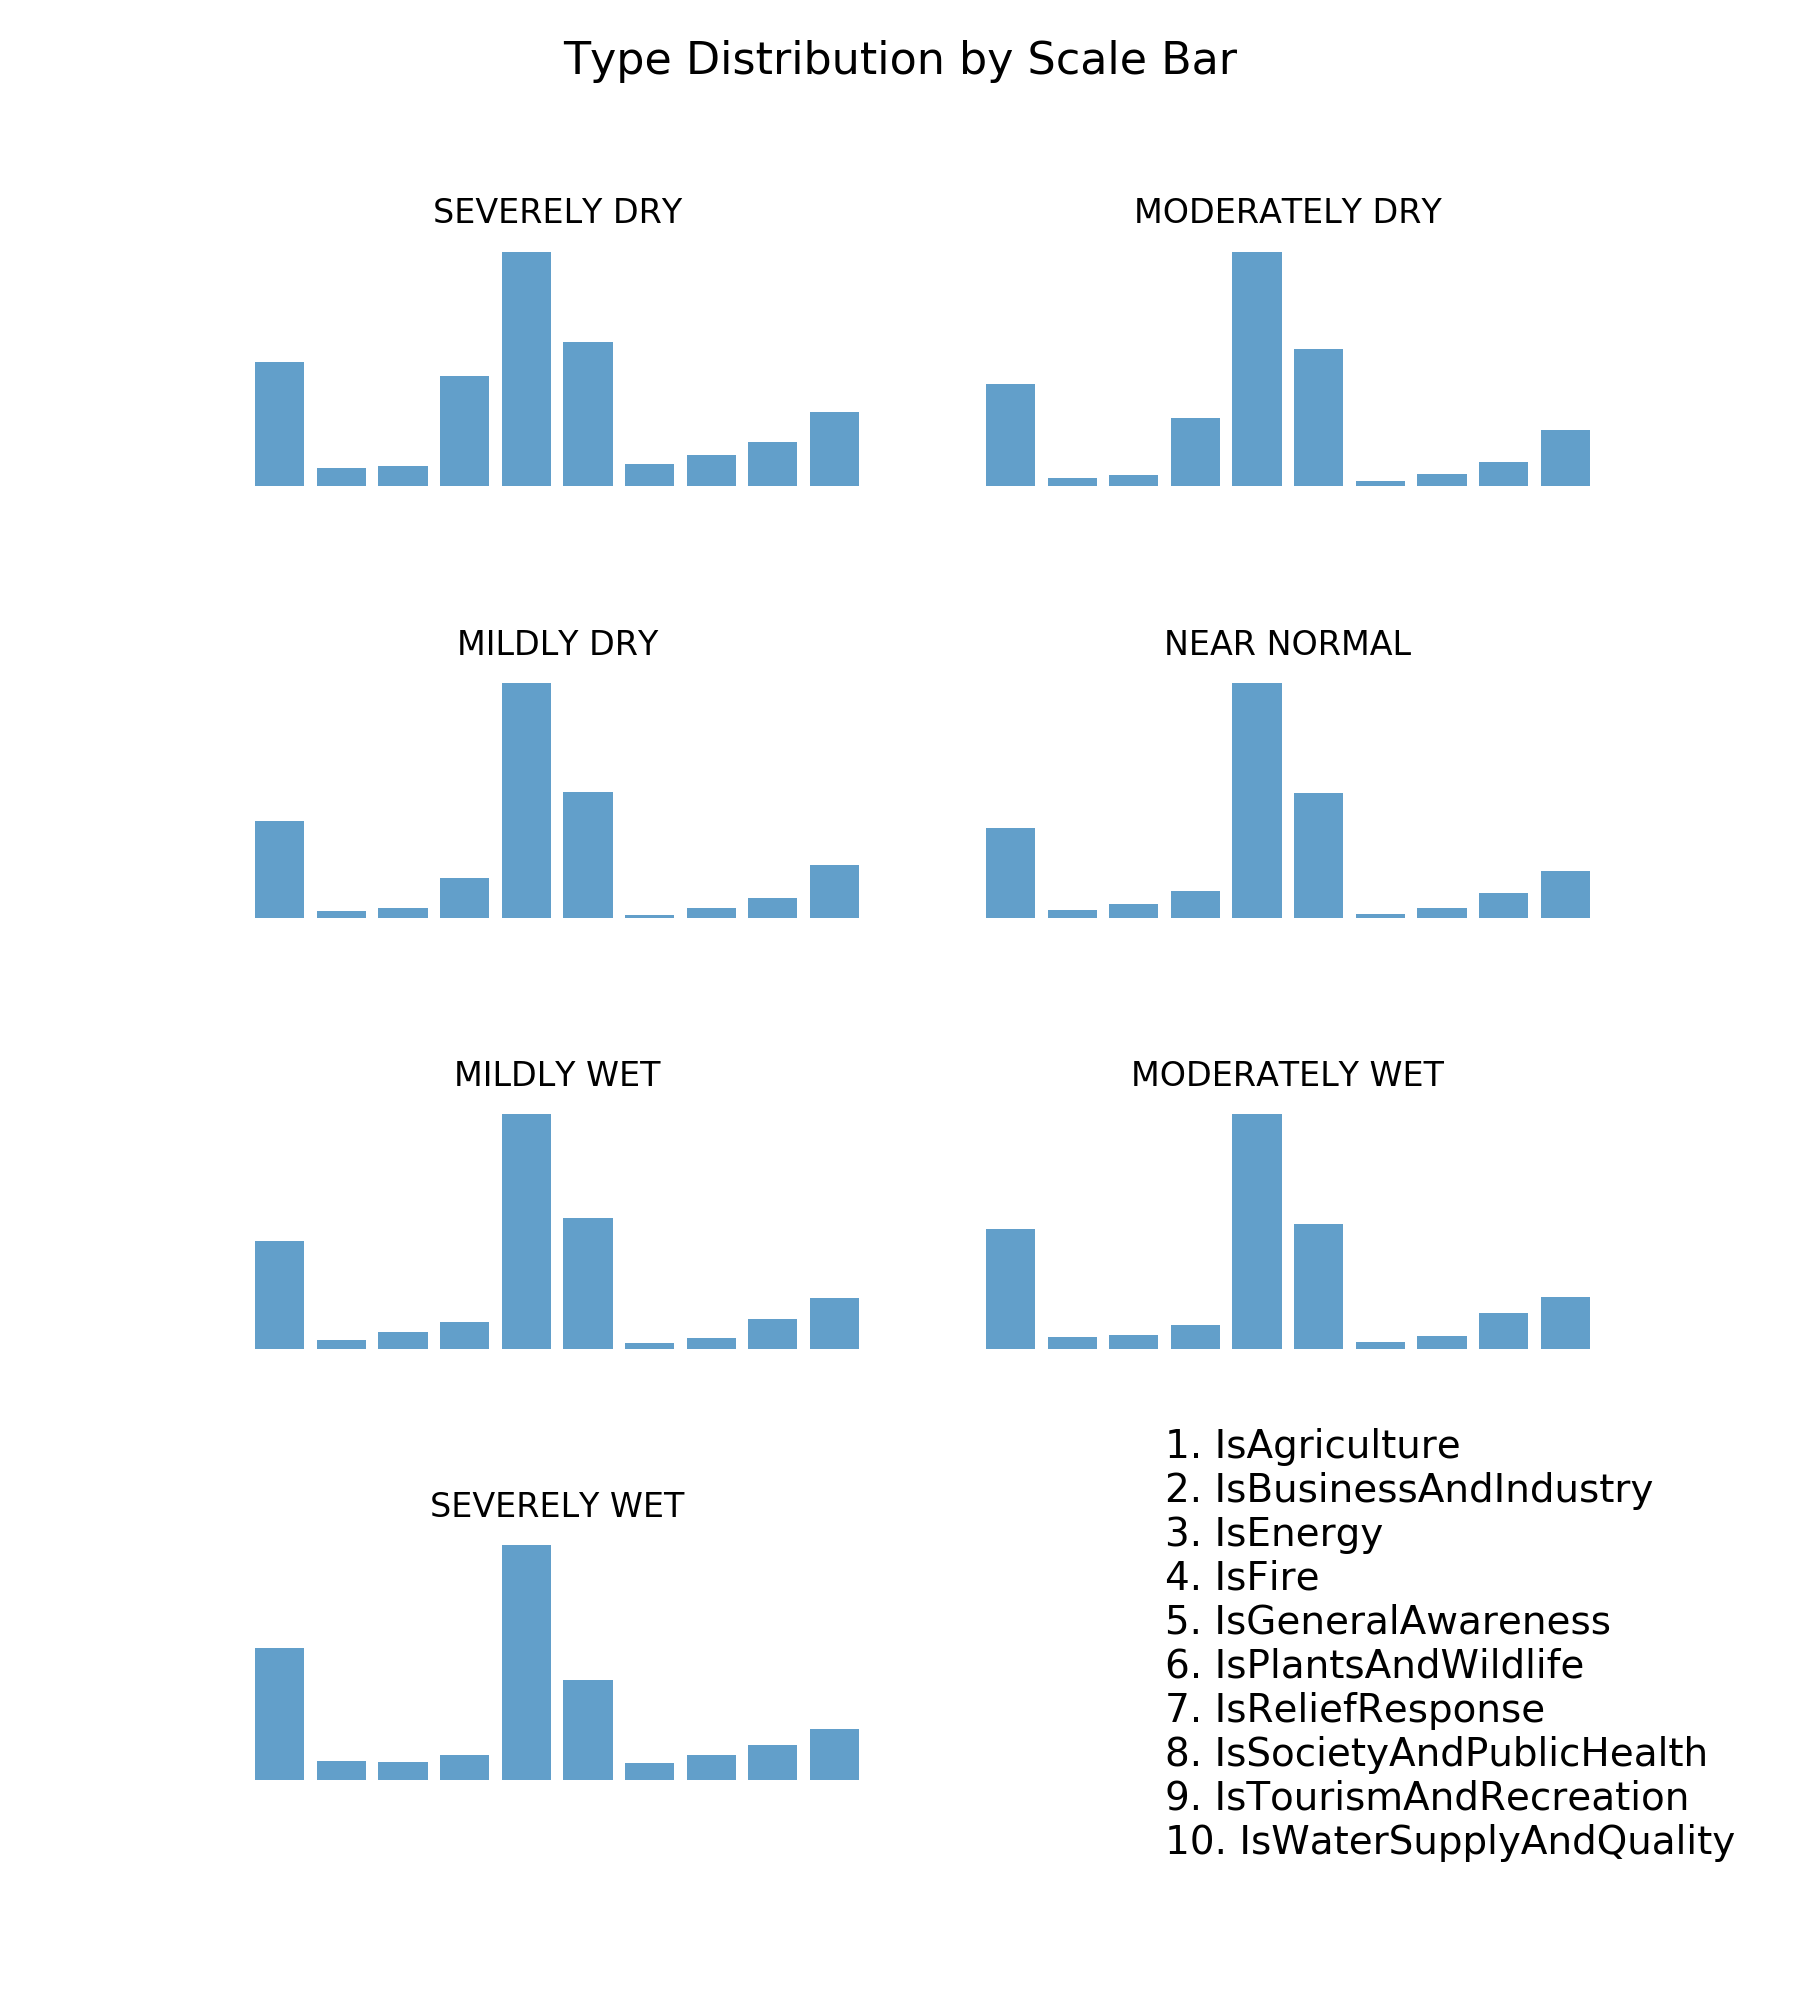

In [90]:
fig, axs = plt.subplots(4, 2, sharex=True, figsize=(9, 10))
#fig.tight_layout()

for i in range(len(condition_map)):
    if i%2 == 0:
        x = int(i/2)
        y = 0
    else:
        x = int((i-1)/2)
        y = 1
    condt = list(condition_map.keys())[i]
    axs[x][y].bar(b_cols, get_row_data(counts_by_condt_df, condt), alpha=0.7)
    axs[x][y].set_title(condt)
    axs[x][y].set_xticks([])
    axs[x][y].set_yticks([])
    for spine in axs[x][y].spines.values():
        spine.set_visible(False)

axs[3][1].set_xticks([])
axs[3][1].set_yticks([])
for spine in axs[3][1].spines.values():
    spine.set_visible(False)
    
b_cols_n = ['1. IsAgriculture', '2. IsBusinessAndIndustry', '3. IsEnergy', 
            '4. IsFire', '5. IsGeneralAwareness', '6. IsPlantsAndWildlife', 
            '7. IsReliefResponse', '8. IsSocietyAndPublicHealth', 
            '9. IsTourismAndRecreation', '10. IsWaterSupplyAndQuality']

axs[3][1].text(2.5, -0.3, '\n'.join(b_cols_n), fontsize=14)

fig.suptitle('Type Distribution by Scale Bar', fontsize=16)
plt.subplots_adjust(hspace=0.75, wspace=0.1)

#### Scale Bar Distribution by Type

<IPython.core.display.Javascript object>


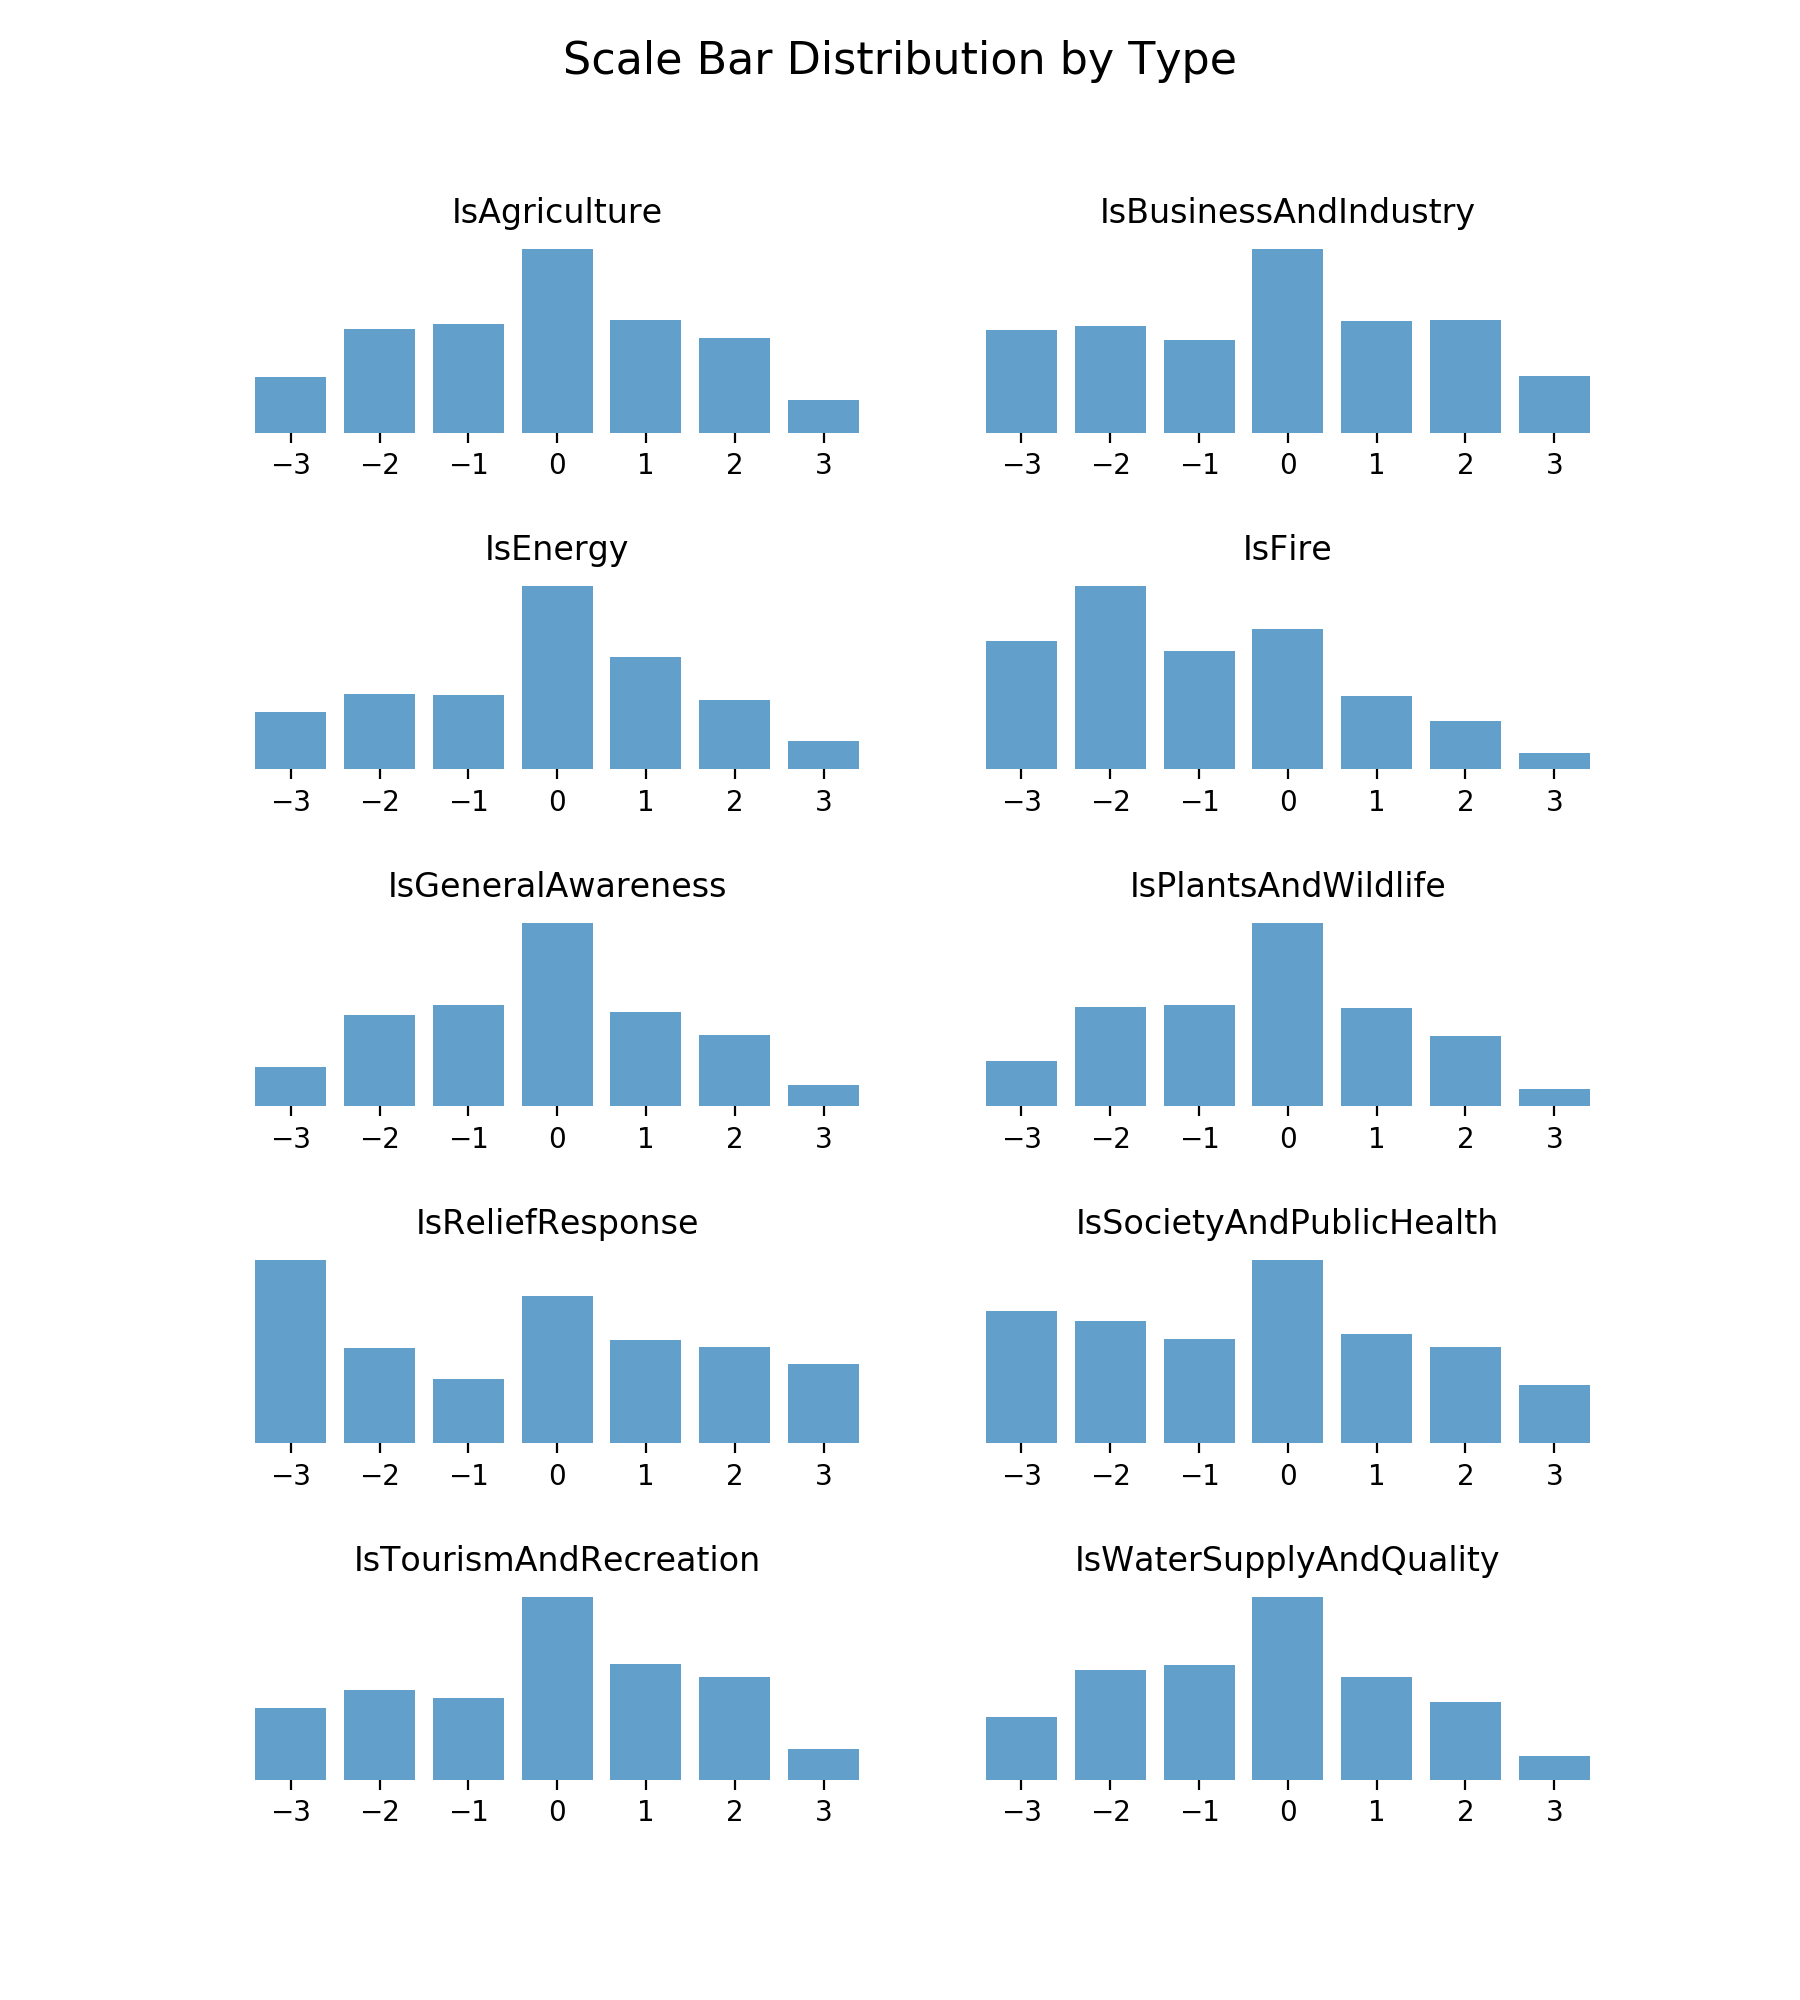

In [89]:
fig, axs = plt.subplots(5, 2, sharex=False, figsize=(9, 10))

for i in range(len(b_cols)):
    if i%2 == 0:
        x = int(i/2)
        y = 0
    else:
        x = int((i-1)/2)
        y = 1
    btype = b_cols[i]
    axs[x][y].bar(list(condition_map.values()), get_row_data(counts_by_type_df, btype), alpha=0.7)
    axs[x][y].set_title(btype)
    axs[x][y].set_xticks(list(condition_map.values()))
    axs[x][y].set_yticks([])
    for spine in axs[x][y].spines.values():
        spine.set_visible(False)

fig.suptitle('Scale Bar Distribution by Type', fontsize=16)
plt.subplots_adjust(hspace=0.75, wspace=0.1)

## Topic Analysis

In [66]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

def model_topics(documents, num_topics = 5, min_df = 25, max_df = 1.0):
    vect = CountVectorizer(min_df=min_df, max_df=max_df, stop_words='english', 
                           token_pattern='\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b')
    X = vect.fit_transform(documents)
    id_map = dict((v, k) for k, v in vect.vocabulary_.items())
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    print('vocabulary size: {}'.format(len(vect.vocabulary_.items())))
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, 
                                               id2word=id_map, passes=25, random_state=31)
    #print()
    display_dataframe(pd.DataFrame(list(zip(*ldamodel.print_topics(num_topics, 5)))[1], columns=['Topics']))
    #print()
    
    topic_names = ['Topic ' + str(i+1) for i in range(num_topics)]
    
    document_topics = ldamodel.get_document_topics(corpus)
    doc_topic_list = []
    doc_topic_prob_list = []
    for doc_topic in document_topics:
        t_group, t_group_prob = (max(doc_topic, key=lambda item:item[1]))
        doc_topic_list.append(t_group)
        doc_topic_prob_list.append(t_group_prob)

    _, counts = np.unique(doc_topic_list, return_counts=True)
    topic_dist = []
    for i in range(len(counts)):
        topic_dist.append((i+1, topic_names[i], counts[i], round(counts[i]/len(document_topics) * 100, 1)))

    topic_dist_pd = pd.DataFrame(topic_dist, columns=['Topic #', 'Topic Name', 'Counts', 'Percent'])
    display_dataframe(topic_dist_pd)
    
    return ldamodel, corpus, vect

In [84]:
n_topics = 10
ldamodel, corpus, vect = model_topics(df_c.Description.values, n_topics, 100, 0.5)

vocabulary size: 1266


,Topics
0,"0.081*""water"" + 0.028*""low"" + 0.027*""week"" + 0.027*""standing"" + 0.025*""river"""
1,"0.139*""moisture"" + 0.131*""soil"" + 0.040*""inch"" + 0.028*""temp"" + 0.026*""surface"""
2,"0.028*""rain"" + 0.021*""dry"" + 0.021*""area"" + 0.018*""water"" + 0.016*""county"""
3,"0.060*""dry"" + 0.058*""grass"" + 0.035*""plants"" + 0.035*""heat"" + 0.025*""ground"""
4,"0.081*""inches"" + 0.063*""average"" + 0.041*""degrees"" + 0.040*""precipitation"" + 0.038*""total"""
5,"0.136*""snow"" + 0.078*""ground"" + 0.044*""wet"" + 0.030*""rain"" + 0.024*""cold"""
6,"0.094*""rain"" + 0.085*""week"" + 0.035*""days"" + 0.022*""dry"" + 0.020*""past"""
7,"0.036*""fields"" + 0.030*""good"" + 0.028*""crops"" + 0.026*""corn"" + 0.023*""farmers"""
8,"0.033*""trees"" + 0.021*""leaves"" + 0.019*""birds"" + 0.016*""seen"" + 0.015*""week"""
9,"0.079*""normal"" + 0.039*""year"" + 0.034*""week"" + 0.034*""precipitation"" + 0.033*""conditions"""


,Topic #,Topic Name,Counts,Percent
0,1,Topic 1,5481,13
1,2,Topic 2,952,2.3
2,3,Topic 3,3506,8.3
3,4,Topic 4,4970,11.8
4,5,Topic 5,1562,3.7
5,6,Topic 6,3238,7.7
6,7,Topic 7,9422,22.4
7,8,Topic 8,3137,7.5
8,9,Topic 9,3999,9.5
9,10,Topic 10,5746,13.7


### Scale Bar Distribution by Topic

In [85]:
document_topics = ldamodel.get_document_topics(corpus)
doc_topic_list = []
doc_topic_prob_list = []
for doc_topic in document_topics:
    t_group, t_group_prob = (max(doc_topic, key=lambda item:item[1]))
    doc_topic_list.append(t_group)
    doc_topic_prob_list.append(t_group_prob)
    
df_c_t = df_c[['ScaleBar', 'Description']]
df_c_t['topic_id'] = doc_topic_list

<IPython.core.display.Javascript object>


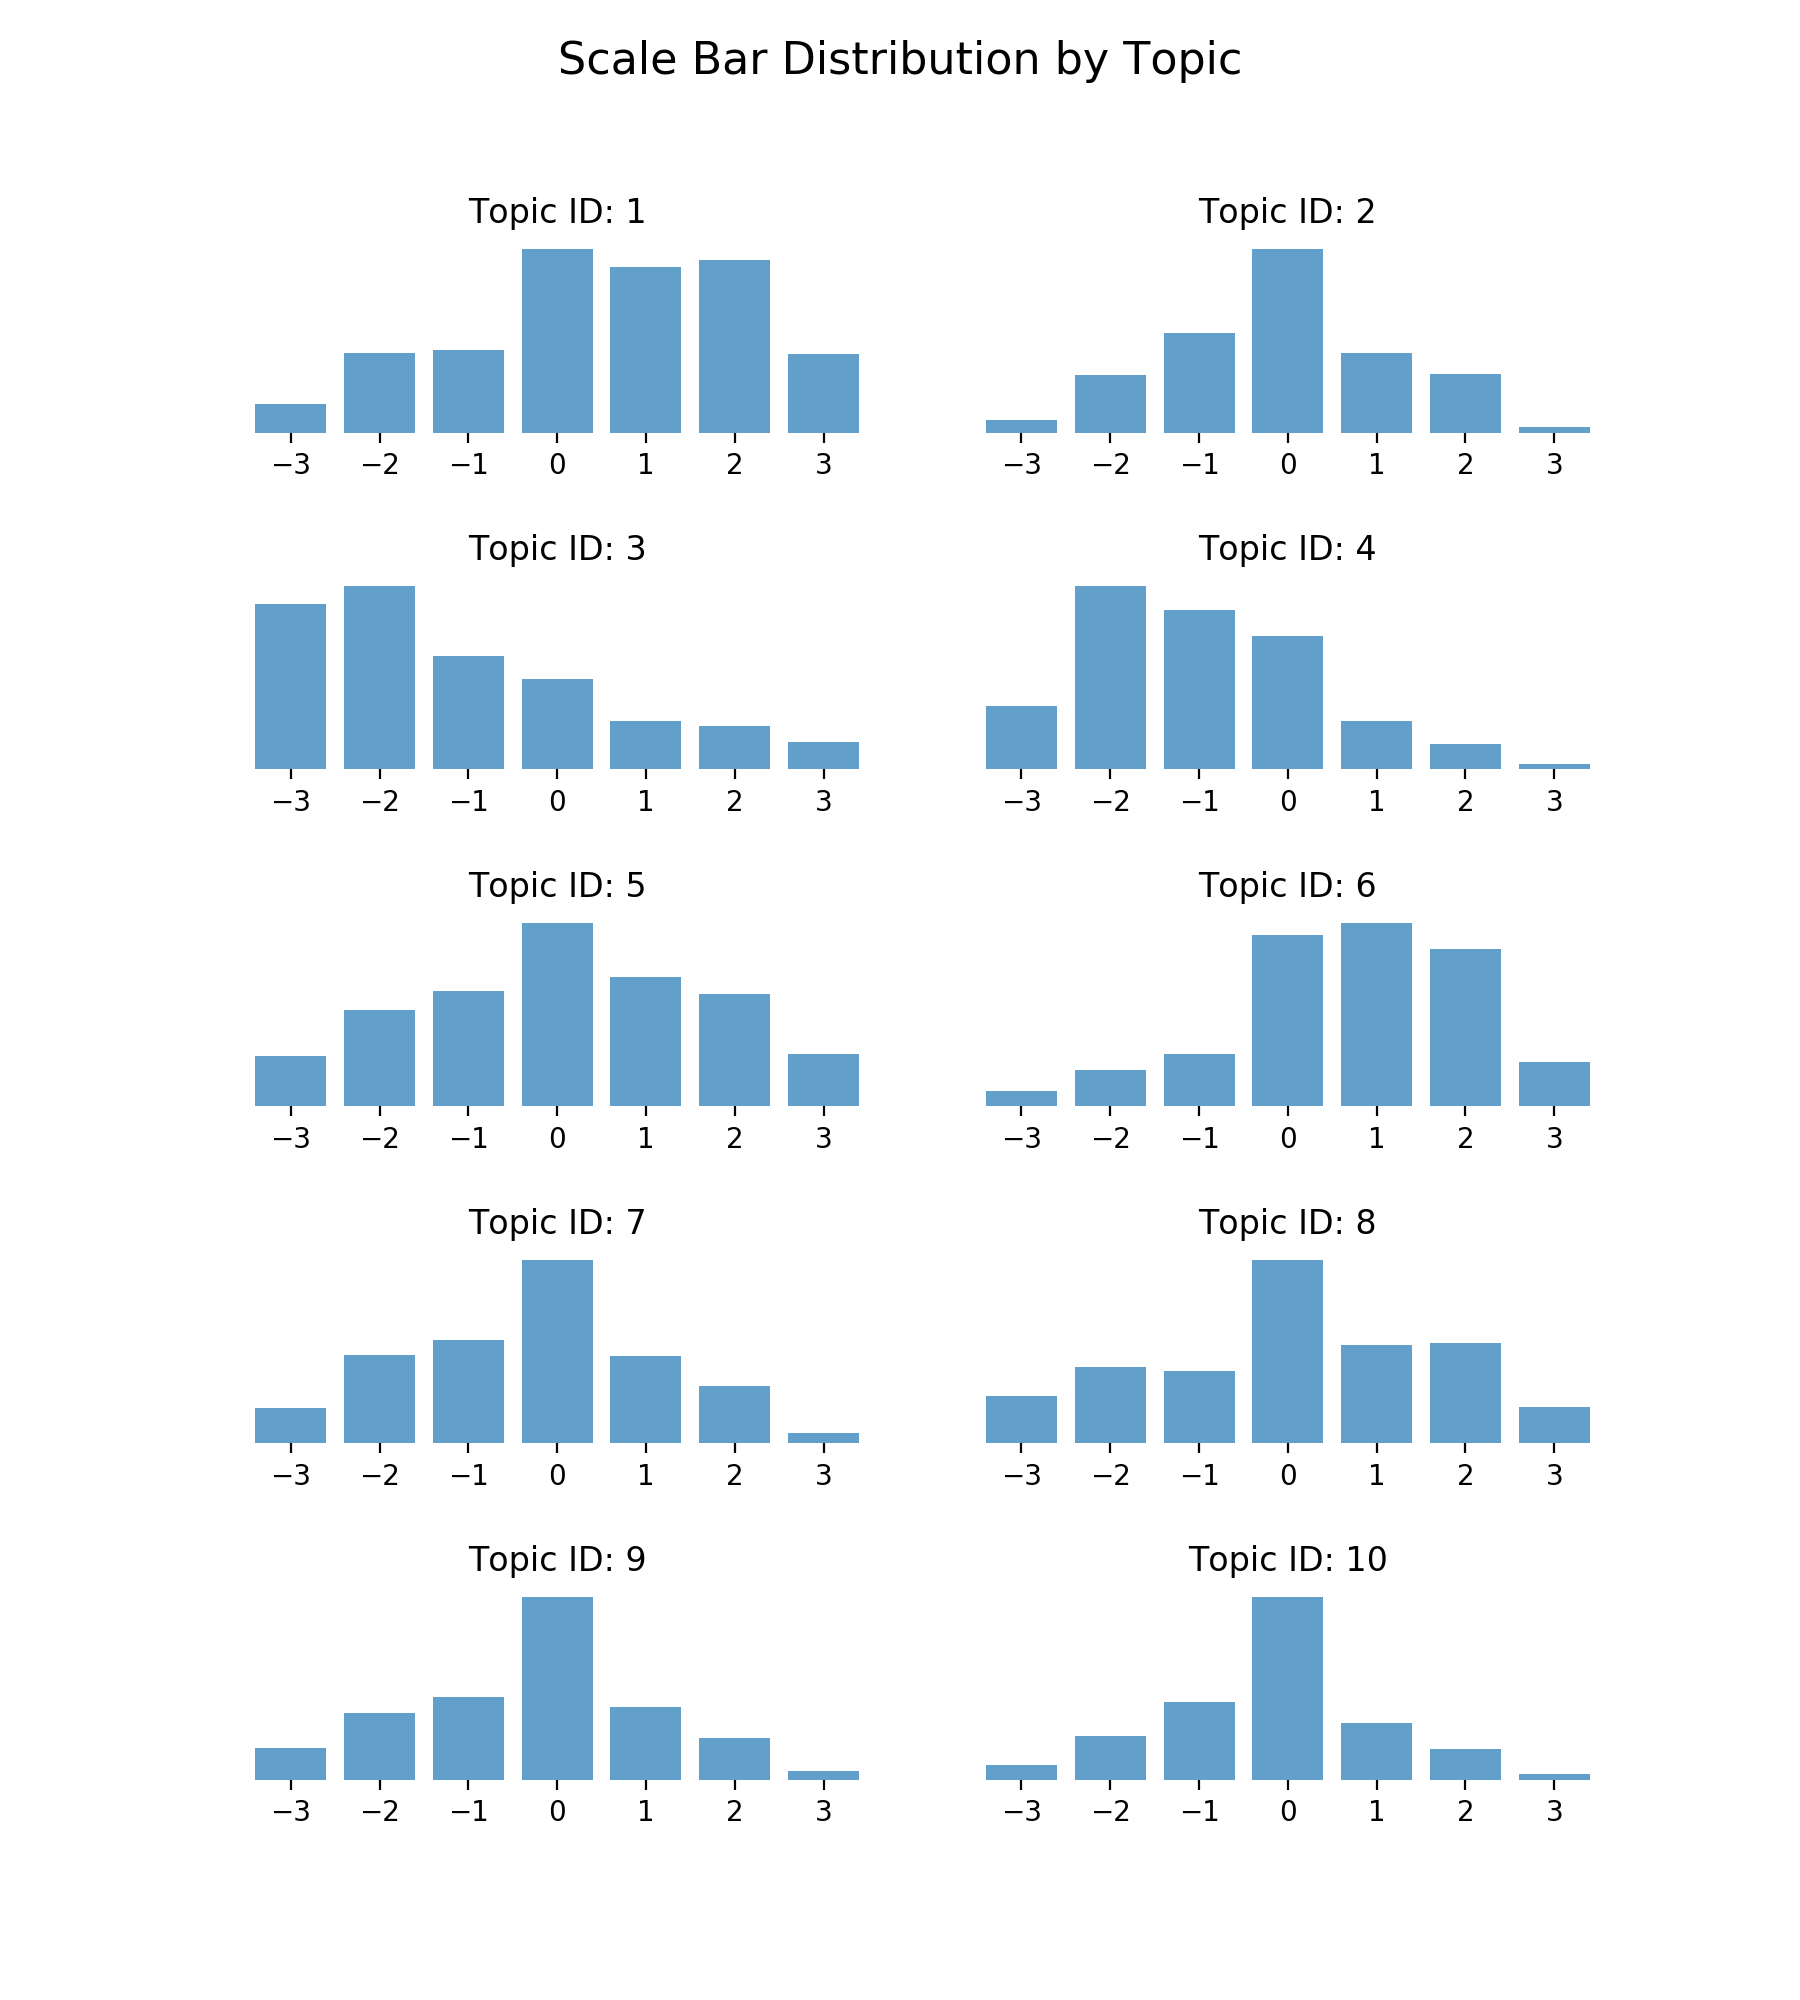

In [91]:
ncols = 2
fig, axs = plt.subplots(int(n_topics/ncols), ncols, sharex=False, figsize=(9, 10))

for i in range(n_topics):
    if i%2 == 0:
        x = int(i/2)
        y = 0
    else:
        x = int((i-1)/2)
        y = 1
    values, counts = np.unique(df_c_t[df_c_t['topic_id'] == i]['ScaleBar'].values, return_counts=True)
    axs[x][y].bar(values, counts, alpha=0.7) #color='lightslategrey')
    axs[x][y].set_title('Topic ID: {}'.format(i+1))
    axs[x][y].set_xticks(values)
    axs[x][y].set_yticks([])
    for spine in axs[x][y].spines.values():
        spine.set_visible(False)

fig.suptitle('Scale Bar Distribution by Topic', fontsize=16)
plt.subplots_adjust(hspace=0.75, wspace=0.1)